http://web.eecs.umich.edu/~mihalcea/downloads.html

In [1]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import semcor
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
import random
import string
from pprint import pprint

### Funzioni usate dall'algoritmo di Lesk

In [2]:
def get_context(sentence):
    # bag of words approach
    sentence.lower()
    tokens = word_tokenize(sentence) 
    tokens = list(filter(lambda token: token not in string.punctuation, tokens))
    wnl = nltk.WordNetLemmatizer()
    ps = PorterStemmer()
    return [ps.stem(wnl.lemmatize(token.lower())) for token in tokens if token not in stopwords.words('english')] 
    #lemma o stemma? solo uno dei due e o entrambi?

def get_gloss_examples(sense):
    gloss = get_context(sense.definition())
    examples = get_context(' '.join((sense).examples()))
    return gloss + examples

def get_overlap(list_1, list_2):
    return [value for value in list_1 if value in list_2]

### Algoritmo di Lesk

In [3]:
def lesk(word, sentence):
    if len(wn.synsets(word)) == 0:
        return "NONE"
    best_sense = wn.synsets(word)[0]
    max_overlap = 0
    context = get_context(sentence)
    sifnature = None
    overlap = None
    for sense in wn.synsets(word):
        signature = get_gloss_examples(sense)
        overlap = get_overlap(context, signature)
        if len(overlap) > max_overlap:
            max_overlap = len(overlap)
            best_sense = sense
    return best_sense

In [4]:
sentence = "i drink wine using a glass"
print(wn.synsets('glass')[1].definition())
lesk('glass', sentence)

a container for holding liquids while drinking


Synset('glass.n.02')

### Funzioni utili per l'esecuzione dell'algoritmo di Lesk su 50 frasi scelte randomicamente da SemCor

In [9]:
def get_rand_elems(array):
    rands = random.sample(range(0, len(array)), 50)
    return [array[i] for i in rands]

def get_rand_elems_2(sentences):
    phrases = []
    extracted = []
    while len(phrases) < 50:
        rand = random.randint(0, len(sentences))
        if '\'NN\'' in str(sentences[rand]) and rand not in extracted and '.n.' in str(sentences[rand]):
            phrases.append(sentences[rand])
            extracted.append(rand)
    return phrases, extracted

def get_nouns(list_of_sentences):
    nouns = []
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()
    for sentence in list_of_sentences:
        for word in sentence:
            if word.pos()[0][1] == 'NN' and '.n.' in str(word):
                nouns.append([word.leaves(), word.label()])
            #prendo solo parole singole per evitare i noun phrase e che inizino con la minuscola così evito i nomi propri.
                #nouns.append([str(word).split('NN ')[1], str(word).split('\'')[1]])
                break
    return nouns    
     
def list_to_string(s):
    str1 = ''
    for ele in s:
        str1 += ele + ' '  
    return str1

### Esecuzione

Frasi annotatate con synset su SemCor

In [6]:
sentences = semcor.sents()
tagged_sentences = semcor.tagged_sents(tag="both")

Selezione randomica di 50 frasi contenenti almeno un sostantivo e indici delle frasi estratte

In [ ]:
#random_sentences, rand = get_rand_elems_2(tagged_sentences)

estrazione di sostantivi con relativi synset dalle frasi estratte

In [ ]:
#nouns = get_nouns(random_sentences)

esecuzione dell'algoritmo di Lesk su ogni sostantivo estratto per 10 volte. confronto delle accuracy dei risultati

In [13]:
EXECUTIONS = 100

In [14]:
current_ex = 0
accuracies = []
while current_ex < EXECUTIONS:
    random_sentences, rand = get_rand_elems_2(tagged_sentences)
    nouns = get_nouns(random_sentences)
    correct = 0
    for i in range(len(nouns)):
        actual_lesk = lesk(nouns[i][0][0], list_to_string(sentences[rand[i]]))
        #print(f"WORD: {nouns[i][0][0]} --> in SENTENCE: {list_to_string(sentences[rand[i]])}") 
        #print(f"LESK SYNSET {actual_lesk} REAL SYNSET: {nouns[i][1]}")
        if "NONE" not in str(actual_lesk):
            if str(actual_lesk).split('\'')[1] in str(nouns[i][1]):
                correct += 1
                #print('Correct\n\n\n')
            else:
                pass
                #print('Wrong\n\n\n')
    print(f"CORRECT ANSWERS: {correct}")
    print(f"TOTAL ANSWERS: {len(nouns)}")
    print(f"ACCURACY: {correct/len(nouns)}\n\n\n")
    accuracies.append(correct/len(nouns))
    current_ex += 1

CORRECT ANSWERS: 26
TOTAL ANSWERS: 50
ACCURACY: 0.52



CORRECT ANSWERS: 23
TOTAL ANSWERS: 49
ACCURACY: 0.46938775510204084



CORRECT ANSWERS: 29
TOTAL ANSWERS: 50
ACCURACY: 0.58



CORRECT ANSWERS: 26
TOTAL ANSWERS: 50
ACCURACY: 0.52



CORRECT ANSWERS: 22
TOTAL ANSWERS: 50
ACCURACY: 0.44



CORRECT ANSWERS: 22
TOTAL ANSWERS: 50
ACCURACY: 0.44



CORRECT ANSWERS: 17
TOTAL ANSWERS: 50
ACCURACY: 0.34



CORRECT ANSWERS: 26
TOTAL ANSWERS: 50
ACCURACY: 0.52



CORRECT ANSWERS: 26
TOTAL ANSWERS: 50
ACCURACY: 0.52



CORRECT ANSWERS: 28
TOTAL ANSWERS: 50
ACCURACY: 0.56



CORRECT ANSWERS: 25
TOTAL ANSWERS: 50
ACCURACY: 0.5



CORRECT ANSWERS: 27
TOTAL ANSWERS: 50
ACCURACY: 0.54



CORRECT ANSWERS: 22
TOTAL ANSWERS: 50
ACCURACY: 0.44



CORRECT ANSWERS: 23
TOTAL ANSWERS: 50
ACCURACY: 0.46



CORRECT ANSWERS: 26
TOTAL ANSWERS: 50
ACCURACY: 0.52



CORRECT ANSWERS: 27
TOTAL ANSWERS: 50
ACCURACY: 0.54



CORRECT ANSWERS: 25
TOTAL ANSWERS: 50
ACCURACY: 0.5



CORRECT ANSWERS: 27
TOTAL ANSWERS: 

andamento dell'accuracy su 100 esecuzioni

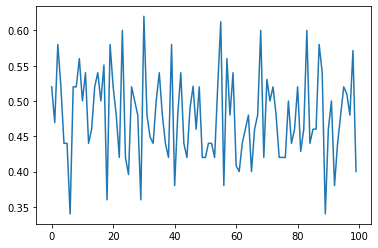

AVG ACCURACY: 0.4783707482993198
MAX ACCURACY: 0.62
MIN ACCURACY: 0.34


In [35]:
plt.plot(accuracies)
plt.show()
print(f"AVG ACCURACY: {sum(accuracies)/len(accuracies)}")
print(f"MAX ACCURACY: {max(accuracies)}")
print(f"MIN ACCURACY: {min(accuracies)}")